In [1]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [2]:
import csv, json, math, os, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [184]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)

In [3]:
homicides = pd.read_excel("allegheny_county/dhs/homicides_CensusBlock_v2.xlsx",dtype={'GEOID10':numpy.str})

In [4]:
homicides[homicides.GEOID10=='420033001002017']

,CLIENT_ID,DOD,CALCAGE,TIME_OF_DEATH,DEATH_CAUSE_DESC,GENDER_DESC,NRACE,NEIGHBORHOOD/MUNICIPALITY,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10
429,433082,2014-03-24,16,00:55:00,FIREARM OR EXPLOSION,Male,Black,KNOXVILLE,42,3,300100,2017,420033001002017


In [5]:
homicides['DOD'].min()

Timestamp('2007-01-02 00:00:00')

In [6]:
hom_tot_per_block = homicides.groupby(['GEOID10'])
for blockid,group in hom_tot_per_block:
    print "%s: %r" % (blockid, len(group))

420030103003000: 1
420030103003003: 3
420030103003004: 1
420030103003010: 1
420030103004002: 1
420030103004016: 1
420030201001019: 1
420030201001022: 1
420030201002020: 1
420030201003021: 2
420030201004004: 1
420030201005042: 1
420030203001010: 1
420030203001017: 1
420030203001034: 2
420030203001088: 1
420030203001093: 1
420030305001004: 2
420030305001015: 1
420030305001026: 1
420030305002003: 1
420030305002004: 1
420030305002005: 2
420030305002022: 1
420030305002023: 1
420030402001014: 2
420030402001022: 1
420030402001024: 1
420030402002005: 1
420030405001007: 1
420030405001012: 1
420030405001013: 1
420030405001016: 1
420030406001025: 1
420030409001015: 1
420030409002005: 1
420030409002012: 1
420030501001007: 2
420030501001009: 1
420030501001015: 1
420030501002003: 3
420030501002004: 1
420030501002008: 4
420030501002012: 1
420030501002017: 2
420030501002020: 1
420030501002021: 1
420030501002025: 2
420030501003000: 1
420030501003002: 1
420030501003020: 1
420030501003027: 1
420030501003

420035523003051: 2
420035524001017: 1
420035524001020: 1
420035524001028: 2
420035524003035: 1
420035524003046: 1
420035604001013: 1
420035604001014: 1
420035604001021: 1
420035604001030: 1
420035606001002: 1
420035606001017: 1
420035606002005: 1
420035606002009: 1
420035606002011: 1
420035606002019: 1
420035606002021: 1
420035606002022: 1
420035610001002: 1
420035610001004: 2
420035610001005: 2
420035610001007: 1
420035610001016: 1
420035610002006: 2
420035610002007: 2
420035611001002: 1
420035611001004: 2
420035611001005: 1
420035611001031: 1
420035612001008: 1
420035612001010: 1
420035612002000: 2
420035612002005: 1
420035612002020: 1
420035612002021: 1
420035614001012: 1
420035614002011: 1
420035614002021: 1
420035614002022: 1
420035614003002: 2
420035614003004: 2
420035614003010: 2
420035614004004: 1
420035614004008: 1
420035615001009: 1
420035615001012: 5
420035615002012: 1
420035615002013: 1
420035615002021: 2
420035615003008: 1
420035615003009: 1
420035615003015: 1
420035615003

## Read 2010 block geoids and 2010 block populations

In [7]:
block_populations = numpy.load('columncache/census2010_block2010/p001001.numpy')
print 'block_populations has', sum(block_populations), 'total people'

block_populations has 308745538 total people


In [8]:
# block_geoids_2010 = [row[0] for row in query_psql("SELECT geoid2010 FROM sf1_2010_block_p001 order by blockidx2010")]
block_geoids_2010 = json.load(open('block_geoids_2010.json'))
print 'There are', len(block_geoids_2010), 'blocks'

assert(len(block_geoids_2010) + 1 == len(block_populations))

There are 11078297 blocks


In [9]:
block_geoids_2010.index('420030103003000')

8107599

## Compute 2010 population by tract and block indices from tract

In [10]:
blockgroup_populations = {}
blockgroup_block_indexes = {}
block_index_map = {}

for block_index_minus_one, block_geoid in enumerate(block_geoids_2010):
    try:
        block_index = block_index_minus_one + 1
        blockgroup_name = block_geoid[0:12] # SSCCCTTTTTTG
        if blockgroup_name not in blockgroup_populations:
            blockgroup_populations[blockgroup_name] = 0
            blockgroup_block_indexes[blockgroup_name] = []
        blockgroup_populations[blockgroup_name] += block_populations[block_index]
        blockgroup_block_indexes[blockgroup_name].append(block_index)
        block_index_map[block_geoid]=block_index
    except:
        print "Error processing %s"

print 'There are', len(blockgroup_populations), 'blockgroups'
print 'blockgroup_populations has', sum(blockgroup_populations.values()), 'people'

There are 217740 blockgroups
blockgroup_populations has 308745538 people


In [44]:
block_index_map['420030103003000']

8107600

## Interpolate and write columns for dotmap data file

In [16]:
output_col = numpy.zeros(block_populations.size, dtype=numpy.float32)
len(output_col)

11078298

In [18]:
!mkdir columncache/ac_dhs_homicides_2017_12_28

In [45]:
for block_id,group in hom_tot_per_block:
    try:
        block_index = block_index_map[block_id]
        input_pop = len(group)
        print '%s (%d) has %d people' % (block_id, block_index, input_pop)
        output_col[block_index] = input_pop 
    except Exception as e:
        print "Error processing %s: %r" % (block_index,e)

output_col_path = 'columncache/ac_dhs_homicides/homicides_2017_12_28.float32'
output_col.tofile(output_col_path + '.tmp')
os.rename(output_col_path + '.tmp', output_col_path)
sys.stdout.write('Created %s with sum %f\n' % (output_col_path, output_col.sum()))

420030103003000 (8107600) has 1 people
420030103003003 (8107603) has 3 people
420030103003004 (8107604) has 1 people
420030103003010 (8107610) has 1 people
420030103004002 (8107625) has 1 people
420030103004016 (8107639) has 1 people
420030201001019 (8107662) has 1 people
420030201001022 (8107665) has 1 people
420030201002020 (8107702) has 1 people
420030201003021 (8107738) has 2 people
420030201004004 (8107747) has 1 people
420030201005042 (8107806) has 1 people
420030203001010 (8107865) has 1 people
420030203001017 (8107872) has 1 people
420030203001034 (8107889) has 2 people
420030203001088 (8107943) has 1 people
420030203001093 (8107948) has 1 people
420030305001004 (8108002) has 2 people
420030305001015 (8108013) has 1 people
420030305001026 (8108024) has 1 people
420030305002003 (8108044) has 1 people
420030305002004 (8108045) has 1 people
420030305002005 (8108046) has 2 people
420030305002022 (8108063) has 1 people
420030305002023 (8108064) has 1 people
420030402001014 (8108079)

420032614002016 (8113060) has 4 people
420032614003000 (8113073) has 1 people
420032614003003 (8113076) has 1 people
420032614004000 (8113086) has 1 people
420032614004002 (8113088) has 1 people
420032614004003 (8113089) has 1 people
420032614004006 (8113092) has 1 people
420032615001002 (8113104) has 1 people
420032615001030 (8113132) has 2 people
420032615002003 (8113139) has 2 people
420032615002040 (8113176) has 2 people
420032615002042 (8113178) has 1 people
420032620001007 (8113192) has 1 people
420032620001026 (8113211) has 1 people
420032620002000 (8113238) has 2 people
420032620002004 (8113242) has 1 people
420032701001011 (8113295) has 1 people
420032701002000 (8113317) has 1 people
420032701002019 (8113336) has 1 people
420032701002021 (8113338) has 1 people
420032701002023 (8113340) has 1 people
420032703001002 (8113351) has 1 people
420032703001017 (8113366) has 1 people
420032703002008 (8113376) has 2 people
420032704001005 (8113394) has 1 people
420032715001024 (8113499)

420035604001013 (8134775) has 1 people
420035604001014 (8134776) has 1 people
420035604001021 (8134783) has 1 people
420035604001030 (8134792) has 1 people
420035606001002 (8134877) has 1 people
420035606001017 (8134892) has 1 people
420035606002005 (8134906) has 1 people
420035606002009 (8134910) has 1 people
420035606002011 (8134912) has 1 people
420035606002019 (8134920) has 1 people
420035606002021 (8134922) has 1 people
420035606002022 (8134923) has 1 people
420035610001002 (8134927) has 1 people
420035610001004 (8134929) has 2 people
420035610001005 (8134930) has 2 people
420035610001007 (8134932) has 1 people
420035610001016 (8134941) has 1 people
420035610002006 (8134949) has 2 people
420035610002007 (8134950) has 2 people
420035611001002 (8134965) has 1 people
420035611001004 (8134967) has 2 people
420035611001005 (8134968) has 1 people
420035611001031 (8134994) has 1 people
420035612001008 (8135007) has 1 people
420035612001010 (8135009) has 1 people
420035612002000 (8135012)

## Create CSV for choropleth

In [52]:
# Write out CSV for doing a blockgroup choropleth
def write_hom_tot_chor_csv(out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("GEOID10,%s\n" % (",".join(map(str,date_range))))
    
    for block_id,group in hom_tot_per_block:
        val=len(group)
        out_data=[block_id]
        
        for year in date_range:
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [53]:
write_hom_tot_chor_csv('allegheny_county/homicides_2017_12_28.csv')

# Homicides per year

In [61]:
import arrow

def dod_to_year(dod):
    ad = arrow.get(str(dod), 'YYYY-MM-DD')
    return ad.year

In [59]:
dod_to_year('2008-01-22')

2008

In [62]:
homicides['death_year'] = homicides['DOD'].map(dod_to_year)

In [63]:
homicides[0:20][['DOD','death_year']]

,DOD,death_year
0,2008-01-22,2008
1,2008-01-22,2008
2,2014-09-10,2014
3,2016-06-26,2016
4,2008-11-29,2008
5,2013-02-28,2013
6,2012-06-24,2012
7,2010-03-14,2010
8,2014-08-16,2014
9,2014-03-29,2014


In [68]:
hom_per_year_block = homicides.groupby(['GEOID10','death_year'])
hom_per_year_map = {}

for block_info,group in hom_per_year_block:
    (block_id,year) = block_info
    block_yr_spec = '%s-%d' % (block_id, year)
    print "%s: %r" % (block_yr_spec, len(group))
    hom_per_year_map[block_yr_spec] = len(group)

420030103003000-2007: 1
420030103003003-2007: 1
420030103003003-2009: 1
420030103003003-2015: 1
420030103003004-2008: 1
420030103003010-2008: 1
420030103004002-2011: 1
420030103004016-2009: 1
420030201001019-2007: 1
420030201001022-2016: 1
420030201002020-2007: 1
420030201003021-2009: 1
420030201003021-2010: 1
420030201004004-2007: 1
420030201005042-2008: 1
420030203001010-2012: 1
420030203001017-2008: 1
420030203001034-2008: 1
420030203001034-2014: 1
420030203001088-2012: 1
420030203001093-2008: 1
420030305001004-2012: 1
420030305001004-2015: 1
420030305001015-2009: 1
420030305001026-2016: 1
420030305002003-2015: 1
420030305002004-2015: 1
420030305002005-2011: 1
420030305002005-2017: 1
420030305002022-2014: 1
420030305002023-2011: 1
420030402001014-2008: 1
420030402001014-2016: 1
420030402001022-2010: 1
420030402001024-2011: 1
420030402002005-2008: 1
420030405001007-2007: 1
420030405001012-2013: 1
420030405001013-2011: 1
420030405001016-2008: 1
420030406001025-2017: 1
420030409001015-

420032509001009-2008: 1
420032509001009-2011: 1
420032509001009-2014: 1
420032509001009-2016: 2
420032509001009-2017: 2
420032509001013-2009: 1
420032509001013-2011: 2
420032509001013-2015: 1
420032509001013-2016: 2
420032509002004-2011: 1
420032509002016-2010: 1
420032509002027-2013: 1
420032602002023-2016: 1
420032602003013-2008: 1
420032602003013-2016: 1
420032607001001-2010: 1
420032607001002-2007: 1
420032607001002-2014: 1
420032609001029-2014: 1
420032609001030-2008: 1
420032609001030-2009: 1
420032609001030-2010: 1
420032609001030-2014: 2
420032609001030-2015: 1
420032609001030-2016: 1
420032609001030-2017: 1
420032609001036-2010: 1
420032609001036-2014: 1
420032614001003-2010: 1
420032614001008-2012: 1
420032614001015-2016: 1
420032614002000-2015: 1
420032614002005-2011: 1
420032614002006-2016: 2
420032614002012-2012: 2
420032614002016-2007: 2
420032614002016-2008: 1
420032614002016-2016: 1
420032614003000-2008: 1
420032614003003-2015: 1
420032614004000-2007: 1
420032614004002-

420035519002049-2013: 1
420035519002066-2017: 1
420035520001031-2017: 1
420035520002004-2010: 1
420035520002009-2007: 1
420035520002024-2015: 1
420035520003003-2012: 1
420035521001028-2014: 1
420035521001048-2007: 1
420035521001050-2015: 1
420035521001057-2008: 1
420035521002020-2008: 1
420035521002020-2009: 1
420035522001007-2014: 6
420035522001014-2009: 1
420035522001035-2017: 2
420035523001001-2017: 1
420035523001012-2016: 1
420035523001026-2011: 1
420035523002021-2015: 1
420035523002033-2017: 1
420035523003003-2008: 1
420035523003011-2016: 1
420035523003017-2008: 1
420035523003023-2013: 1
420035523003029-2007: 2
420035523003030-2009: 1
420035523003036-2009: 1
420035523003037-2016: 1
420035523003039-2010: 1
420035523003051-2013: 2
420035524001017-2017: 1
420035524001020-2015: 1
420035524001028-2011: 1
420035524001028-2014: 1
420035524003035-2015: 1
420035524003046-2015: 1
420035604001013-2010: 1
420035604001014-2016: 1
420035604001021-2013: 1
420035604001030-2016: 1
420035606001002-

In [71]:
# Write out CSV for doing a blockgroup choropleth
def write_hom_yr_chor_csv(out_path):
    date_range = range(2007, 2018)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("GEOID10,%s\n" % (",".join(map(str,date_range))))
    
    for block_id,group in hom_tot_per_block:
        out_data=[block_id]
        
        for year in date_range:
            block_yr_spec = '%s-%d' % (block_id, year)
            val=0 
            if(block_yr_spec in hom_per_year_map):
                val = hom_per_year_map[block_yr_spec]
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [72]:
write_hom_yr_chor_csv('allegheny_county/homicides_per_year_2017_12_28.csv')

## Homicides per neighborhood per year

In [73]:
homicides['NEIGHBORHOOD/MUNICIPALITY'].value_counts()

MCKEESPORT                   83
WILKINSBURG                  61
PENN HILLS                   55
HOMEWOOD SOUTH               53
HOMEWOOD NORTH               33
MIDDLE HILL                  28
DUQUESNE                     28
PERRY SOUTH                  27
EAST LIBERTY                 21
KNOXVILLE                    21
LINCOLN-LEMINGTON-BELMAR     20
CLAIRTON                     20
GARFIELD                     20
LARIMER                      19
MCKEES ROCKS                 18
EAST HILLS                   18
WEST MIFFLIN                 17
BELTZHOOVER                  16
BEDFORD DWELLINGS            16
FINEVIEW                     16
MARSHALL-SHADELAND           15
SHERADEN                     15
TERRACE VILLAGE              14
HOMESTEAD                    14
NORTH BRADDOCK               13
STOWE                        12
SWISSVALE                    12
RANKIN                       12
NORTHVIEW HEIGHT             11
HAZELWOOD                    11
                             ..
OAKWOOD 

In [86]:
block_to_nhbd_map = {}

for block_id,group in hom_tot_per_block:
    try:
        nhbd = group.iloc[0]['NEIGHBORHOOD/MUNICIPALITY']
        block_to_nhbd_map[block_id] = nhbd
    except Exception as e:
        print "Error processing %s: %r" % (block_id,e)

In [87]:
block_to_nhbd_map

{'420030103003000': u'BLUFF',
 '420030103003003': u'BLUFF',
 '420030103003004': u'BLUFF',
 '420030103003010': u'BLUFF',
 '420030103004002': u'BLUFF',
 '420030103004016': u'BLUFF',
 '420030201001019': u'GOLDEN TRIANGLE',
 '420030201001022': u'GOLDEN TRIANGLE',
 '420030201002020': u'GOLDEN TRIANGLE',
 '420030201003021': u'GOLDEN TRIANGLE',
 '420030201004004': u'GOLDEN TRIANGLE',
 '420030201005042': u'GOLDEN TRIANGLE',
 '420030203001010': u'STRIP DISTRICT',
 '420030203001017': u'STRIP DISTRICT',
 '420030203001034': u'STRIP DISTRICT',
 '420030203001088': u'STRIP DISTRICT',
 '420030203001093': u'STRIP DISTRICT',
 '420030305001004': u'CRAWFORD-ROBERTS',
 '420030305001015': u'CRAWFORD-ROBERTS',
 '420030305001026': u'CRAWFORD-ROBERTS',
 '420030305002003': u'CRAWFORD-ROBERTS',
 '420030305002004': u'CRAWFORD-ROBERTS',
 '420030305002005': u'CRAWFORD-ROBERTS',
 '420030305002022': u'BLUFF',
 '420030305002023': u'CRAWFORD-ROBERTS',
 '420030402001014': u'WEST OAKLAND',
 '420030402001022': u'WEST OAKL

In [100]:
hom_per_nhbd_year = homicides.groupby(['NEIGHBORHOOD/MUNICIPALITY','death_year'])
hom_per_nhbd_year_map = {}

for nhbd_info,group in hom_per_nhbd_year:
    (nhbd,year) = nhbd_info
    nhbd_yr_spec = '%s-%d' % (nhbd, year)
    print "%s: %r" % (nhbd_yr_spec, len(group))
    hom_per_nhbd_year_map[nhbd_yr_spec] = len(group)

ALLEGHENY CENTER-2010: 1
ALLEGHENY CENTER-2011: 1
ALLEGHENY WEST-2010: 1
ALLENTOWN-2007: 1
ALLENTOWN-2008: 2
ALLENTOWN-2012: 1
ALLENTOWN-2014: 1
ALLENTOWN-2015: 1
ALLENTOWN-2016: 3
ARLINGTON-2007: 1
ARLINGTON-2008: 2
ARLINGTON-2011: 1
ARLINGTON-2015: 1
ARLINGTON HEIGHTS-2009: 1
BALDWIN BOROUGH-2010: 1
BALDWIN BOROUGH-2011: 1
BALDWIN BOROUGH-2012: 1
BALDWIN BOROUGH-2015: 1
BALDWIN BOROUGH-2016: 1
BALDWIN BOROUGH-2017: 1
BALDWIN TOWNSHIP-2007: 1
BANKSVILLE-2008: 1
BEDFORD DWELLINGS-2007: 2
BEDFORD DWELLINGS-2008: 4
BEDFORD DWELLINGS-2010: 1
BEDFORD DWELLINGS-2011: 4
BEDFORD DWELLINGS-2012: 1
BEDFORD DWELLINGS-2013: 1
BEDFORD DWELLINGS-2014: 2
BEDFORD DWELLINGS-2017: 1
BEECHVIEW-2010: 1
BEECHVIEW-2015: 1
BELLEVUE-2009: 3
BELLEVUE-2010: 1
BELLEVUE-2014: 1
BELLEVUE-2016: 1
BELTZHOOVER-2007: 1
BELTZHOOVER-2008: 1
BELTZHOOVER-2009: 2
BELTZHOOVER-2010: 1
BELTZHOOVER-2011: 1
BELTZHOOVER-2012: 1
BELTZHOOVER-2013: 4
BELTZHOOVER-2014: 2
BELTZHOOVER-2015: 1
BELTZHOOVER-2016: 1
BELTZHOOVER-2017: 1
B

In [101]:
hom_per_nhbd_year_map

{u'ALLEGHENY CENTER-2010': 1,
 u'ALLEGHENY CENTER-2011': 1,
 u'ALLEGHENY WEST-2010': 1,
 u'ALLENTOWN-2007': 1,
 u'ALLENTOWN-2008': 2,
 u'ALLENTOWN-2012': 1,
 u'ALLENTOWN-2014': 1,
 u'ALLENTOWN-2015': 1,
 u'ALLENTOWN-2016': 3,
 u'ARLINGTON HEIGHTS-2009': 1,
 u'ARLINGTON-2007': 1,
 u'ARLINGTON-2008': 2,
 u'ARLINGTON-2011': 1,
 u'ARLINGTON-2015': 1,
 u'BALDWIN BOROUGH-2010': 1,
 u'BALDWIN BOROUGH-2011': 1,
 u'BALDWIN BOROUGH-2012': 1,
 u'BALDWIN BOROUGH-2015': 1,
 u'BALDWIN BOROUGH-2016': 1,
 u'BALDWIN BOROUGH-2017': 1,
 u'BALDWIN TOWNSHIP-2007': 1,
 u'BANKSVILLE-2008': 1,
 u'BEDFORD DWELLINGS-2007': 2,
 u'BEDFORD DWELLINGS-2008': 4,
 u'BEDFORD DWELLINGS-2010': 1,
 u'BEDFORD DWELLINGS-2011': 4,
 u'BEDFORD DWELLINGS-2012': 1,
 u'BEDFORD DWELLINGS-2013': 1,
 u'BEDFORD DWELLINGS-2014': 2,
 u'BEDFORD DWELLINGS-2017': 1,
 u'BEECHVIEW-2010': 1,
 u'BEECHVIEW-2015': 1,
 u'BELLEVUE-2009': 3,
 u'BELLEVUE-2010': 1,
 u'BELLEVUE-2014': 1,
 u'BELLEVUE-2016': 1,
 u'BELTZHOOVER-2007': 1,
 u'BELTZHOOVER-2

In [104]:
# Write out CSV for neighborhood per year
def write_hom_nhbd_yr_chor_csv(out_path):
    date_range = range(2007, 2018)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("GEOID10,%s\n" % (",".join(map(str,date_range))))
    
    for block_id,group in hom_tot_per_block:
        out_data=[block_id]
        nhbd=block_to_nhbd_map[block_id]
        
        for year in date_range:
            block_yr_spec = '%s-%d' % (block_id, year)
            nhbd_yr_spec = '%s-%d' % (nhbd, year)
            val=0 
            if(block_yr_spec in hom_per_year_map and nhbd_yr_spec in hom_per_nhbd_year_map):
                val = hom_per_nhbd_year_map[nhbd_yr_spec]
            #print "%s: %d" % (nhbd_yr_spec,val)
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()


In [105]:
write_hom_nhbd_yr_chor_csv('allegheny_county/homicides_per_nhbd_year_2017_12_28-b.csv')

## Homicides per region per year

In [205]:
nhbd_to_region_map = {
    'ALLEGHENY CENTER':1,
    'ALLEGHENY WEST':1,
    'BRIGHTON HEIGHTS':1,
    'CALIFORNIA-KIRKBRIDE':1,
    'CENTRAL NORTHSIDE':1,
    'CHATEAU':1,
    'EAST ALLEGHENY':1,
    'FINEVIEW':1,
    'MANCHESTER':1,
    'MARSHALL-SHADELAND':1,
    'NORTH SHORE':1,
    'NORTHVIEW HEIGHT':1,
    'PERRY NORTH':1,
    'PERRY SOUTH':1,
    'SPRING GARDEN':1,
    'SPRING HILL-CITY VIEW':1,
    'SUMMER HILL':1,
    'TROY HILL':1,

    'MIDDLE HILL':2,
  
    'BELTZHOOVER':3,
    'KNOXVILLE':3,
    'MOUNT OLIVER NEIGHBORHOOD':3,
    'SOUTH SIDE FLATS':3,
    'SOUTH SIDE SLOPES':3,
    
    'HOMEWOOD NORTH':4,
    'HOMEWOOD SOUTH':4,
    'HOMEWOOD WEST':4,
    'PENN HILLS':4,
    'WILKINSBURG':4,
    
    'BRADDOCK':5,
    'DUQUESNE':5,
    'MCKEESPORT':5,
    'RANKIN':5
}

In [202]:
# Anne's modifications based on eyballing the map and 
# filling in gaps
nhbd_to_region_map['BEDFORD DWELLINGS'] = 2
nhbd_to_region_map['TERRACE VILLAGE'] = 2
nhbd_to_region_map['CRAWFORD-ROBERTS'] = 2
nhbd_to_region_map['BLUFF'] = 2

nhbd_to_region_map['ALLENTOWN'] = 3
nhbd_to_region_map['MOUNT OLIVER BORO']=3
nhbd_to_region_map['ARLINGTON']=3
nhbd_to_region_map['ARLINGTON HEIGHTS']=3
nhbd_to_region_map['SAINT CLAIR']=3

nhbd_to_region_map['EAST HILLS'] = 4

nhbd_to_region_map['NORTH BRADDOCK'] = 5
#nhbd_to_region_map['WEST MIFFLIN'] = 5
#nhbd_to_region_map[] = 5
#nhbd_to_region_map[] = 5

In [203]:
all_nhbds = set(list(homicides['NEIGHBORHOOD/MUNICIPALITY'].unique())).union(nhbd_to_region_map.keys())

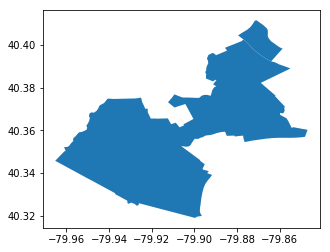

In [192]:
nhbd_gj_out[(nhbd_gj_out.NAME=='WEST MIFFLIN') | (nhbd_gj_out.NAME=='BRADDOCK')].plot()

In [155]:
all_nhbds

{u'ALLEGHENY CENTER',
 u'ALLEGHENY WEST',
 u'ALLENTOWN',
 u'ARLINGTON',
 u'ARLINGTON HEIGHTS',
 u'BALDWIN BOROUGH',
 u'BALDWIN TOWNSHIP',
 u'BANKSVILLE',
 u'BEDFORD DWELLINGS',
 u'BEECHVIEW',
 u'BELLEVUE',
 u'BELTZHOOVER',
 u'BEN AVON',
 u'BETHEL PARK',
 u'BLOOMFIELD',
 u'BLUFF',
 u'BRACKENRIDGE',
 u'BRADDOCK',
 u'BRADDOCK HILLS',
 u'BRENTWOOD',
 u'BRIGHTON HEIGHTS',
 u'BROOKLINE',
 u'CALIFORNIA-KIRKBRIDE',
 u'CARNEGIE',
 u'CARRICK',
 u'CENTRAL LAWRENCEVILLE',
 u'CENTRAL NORTHSIDE',
 u'CENTRAL OAKLAND',
 u'CHARTIERS CITY',
 'CHATEAU',
 u'CHURCHILL',
 u'CLAIRTON',
 u'COLLIER',
 u'CORAOPOLIS',
 u'CRAFTON',
 u'CRAFTON HEIGHTS',
 u'CRAWFORD-ROBERTS',
 u'DORMONT',
 u'DRAVOSBURG',
 u'DUQUESNE',
 u'DUQUESNE HEIGHTS',
 u'EAST ALLEGHENY',
 u'EAST CARNEGIE',
 u'EAST HILLS',
 u'EAST LIBERTY',
 u'EAST PITTSBURGH',
 u'ELIZABETH TOWNSHIP',
 u'ELLIOTT',
 u'ESPLEN',
 u'ETNA',
 u'FAIRYWOOD',
 u'FINDLAY',
 u'FINEVIEW',
 u'FOREST HILLS',
 u'FRAZER',
 u'FRIENDSHIP',
 u'GARFIELD',
 u'GLASSPORT',
 u'GLEN HA

In [156]:
for nhbd in sorted(all_nhbds):
    try:
        region = nhbd_to_region_map[nhbd]
        print "%s: %d" % (nhbd, region)
    except:
        print "  %s: MISSING" % (nhbd)

ALLEGHENY CENTER: 1
ALLEGHENY WEST: 1
  ALLENTOWN: MISSING
  ARLINGTON: MISSING
  ARLINGTON HEIGHTS: MISSING
  BALDWIN BOROUGH: MISSING
  BALDWIN TOWNSHIP: MISSING
  BANKSVILLE: MISSING
  BEDFORD DWELLINGS: MISSING
  BEECHVIEW: MISSING
  BELLEVUE: MISSING
BELTZHOOVER: 3
  BEN AVON: MISSING
  BETHEL PARK: MISSING
  BLOOMFIELD: MISSING
  BLUFF: MISSING
  BRACKENRIDGE: MISSING
BRADDOCK: 5
  BRADDOCK HILLS: MISSING
  BRENTWOOD: MISSING
BRIGHTON HEIGHTS: 1
  BROOKLINE: MISSING
CALIFORNIA-KIRKBRIDE: 1
  CARNEGIE: MISSING
  CARRICK: MISSING
  CENTRAL LAWRENCEVILLE: MISSING
CENTRAL NORTHSIDE: 1
  CENTRAL OAKLAND: MISSING
  CHARTIERS CITY: MISSING
CHATEAU: 1
  CHURCHILL: MISSING
  CLAIRTON: MISSING
  COLLIER: MISSING
  CORAOPOLIS: MISSING
  CRAFTON: MISSING
  CRAFTON HEIGHTS: MISSING
  CRAWFORD-ROBERTS: MISSING
  DORMONT: MISSING
  DRAVOSBURG: MISSING
DUQUESNE: 5
  DUQUESNE HEIGHTS: MISSING
EAST ALLEGHENY: 1
  EAST CARNEGIE: MISSING
EAST HILLS: 4
  EAST LIBERTY: MISSING
  EAST PITTSBURGH: MISSI

In [208]:
def nhbd_to_region(nhbd):
    if nhbd in nhbd_to_region_map:
        return nhbd_to_region_map[nhbd]
    else:
        return None

homicides['region'] = homicides['NEIGHBORHOOD/MUNICIPALITY'].map(nhbd_to_region)
hom_per_year_per_region = homicides[~pd.isna(homicides.region)].groupby(['region','death_year'])

In [215]:
for region_info,group in hom_per_year_per_region:
    (region,year) = region_info
    region_yr_spec = '%d-%d' % (region, year)
    print "%s: %r" % (region_yr_spec, len(group))
    hom_per_year_map[region_yr_spec] = len(group)

1-2007: 9
1-2008: 13
1-2009: 8
1-2010: 10
1-2011: 11
1-2012: 6
1-2013: 4
1-2014: 9
1-2015: 13
1-2016: 20
1-2017: 11
2-2007: 3
2-2008: 3
2-2009: 2
2-2010: 3
2-2011: 5
2-2012: 2
2-2013: 2
2-2014: 2
2-2015: 2
2-2017: 4
3-2007: 4
3-2008: 2
3-2009: 3
3-2010: 4
3-2011: 4
3-2012: 4
3-2013: 5
3-2014: 8
3-2015: 4
3-2016: 4
3-2017: 5
4-2007: 18
4-2008: 21
4-2009: 13
4-2010: 21
4-2011: 12
4-2012: 20
4-2013: 18
4-2014: 26
4-2015: 16
4-2016: 25
4-2017: 17
5-2007: 12
5-2008: 8
5-2009: 12
5-2010: 10
5-2011: 8
5-2012: 13
5-2013: 12
5-2014: 17
5-2015: 14
5-2016: 7
5-2017: 16


# Neighborhood geojson

In [20]:
nhbd_gj = gpd.read_file('allegheny_county/dhs/AllegCo_Munis_PghNeighs.geojson')
nhbd_gj

,Name,description,tessellate,extrude,visibility,snippet,geometry
0,Summer Hill,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.00776399999999 40.483051 5896...
1,Perry North,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.02570799999999 40.482791 5896...
2,Brighton Heights,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.02789199999999 40.491075 5896...
3,Highland Park,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-79.90597099999999 40.485224 5896...
4,Northview Height,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.00776399999999 40.483051 5896...
5,Marshall-Shadeland,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.02570799999999 40.482791 5896...
6,Perry South,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON Z ((-80.017413 40.477262 5896, -80.01..."
7,Spring Garden,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-79.99327700000001 40.461182 5896...
8,Spring Hill-City View,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON Z ((-80.005117 40.472254 5896, -80.00..."
9,East Liberty,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON Z ((-79.92833 40.472339 5896, -79.929..."


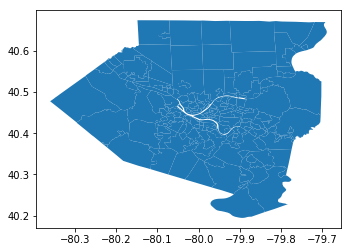

In [21]:
nhbd_gj.plot()

In [22]:
nhbd_gj['NAME']=nhbd_gj['Name'].map(lambda x: str(x).upper())
nhbd_gj=nhbd_gj.set_index('NAME')
nhbd_gj

,Name,description,tessellate,extrude,visibility,snippet,geometry
NAME,,,,,,,
SUMMER HILL,Summer Hill,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.00776399999999 40.483051 5896...
PERRY NORTH,Perry North,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.02570799999999 40.482791 5896...
BRIGHTON HEIGHTS,Brighton Heights,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.02789199999999 40.491075 5896...
HIGHLAND PARK,Highland Park,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-79.90597099999999 40.485224 5896...
NORTHVIEW HEIGHT,Northview Height,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.00776399999999 40.483051 5896...
MARSHALL-SHADELAND,Marshall-Shadeland,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-80.02570799999999 40.482791 5896...
PERRY SOUTH,Perry South,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON Z ((-80.017413 40.477262 5896, -80.01..."
SPRING GARDEN,Spring Garden,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,(POLYGON Z ((-79.99327700000001 40.461182 5896...
SPRING HILL-CITY VIEW,Spring Hill-City View,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON Z ((-80.005117 40.472254 5896, -80.00..."


# Flatten to 2D

In [23]:
from shapely.geometry import Polygon, MultiPolygon, shape, Point
import geopandas as gp
def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
    return new_geo

In [24]:
nhbd_gj.geometry = convert_3D_2D(nhbd_gj.geometry)

# Figure out which neighborhoods are in Pittsburgh proper

In [17]:
pgh_gj = gpd.read_file('allegheny_county/pgh/pgh.geojson')
pgh_gj['in_pgh']=True

In [172]:
# Buffer Pittsburgh boundary out a bit so checking if a given neighborhood is within PGH is more robust
pgh_outbuff=pgh_gj.geometry
#.buffer(0.0015)


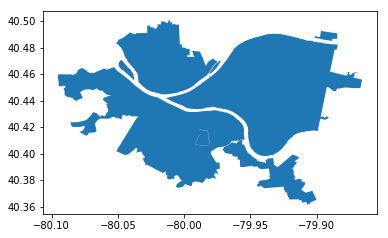

In [173]:
pgh_outbuff.plot()

In [ ]:
from shapely.ops import cascaded_union
pgh_outbuff_all=cascaded_union(pgh_outbuff)

In [178]:
list(pgh_outbuff_all)

In [179]:
pgh_outbuff_df = pd.DataFrame({'city_name':pd.Series(['Pittsburgh','Pittsburgh','Pittsburgh','Pittsburgh','Pittsburgh','Pittsburgh','Pittsburgh'])})
pgh_outbuff_df

,city_name
0,Pittsburgh
1,Pittsburgh
2,Pittsburgh
3,Pittsburgh
4,Pittsburgh
5,Pittsburgh
6,Pittsburgh


In [180]:
pgh_outbuff_gj=gpd.GeoDataFrame(pgh_outbuff_df, geometry=pd.Series(pgh_outbuff_all),crs={'init': 'epsg:4326'})
pgh_outbuff_gj

,city_name,geometry
0,Pittsburgh,"POLYGON ((-79.9351952910752 40.3964746147334, ..."
1,Pittsburgh,"POLYGON ((-80.00410666529559 40.3740446208956,..."
2,Pittsburgh,"POLYGON ((-79.8840416957775 40.4824565982262, ..."
3,Pittsburgh,"POLYGON ((-79.9015036953717 40.487439836265, -..."
4,Pittsburgh,"POLYGON ((-80.0410514221517 40.4639492782794, ..."
5,Pittsburgh,"POLYGON ((-79.9745291224836 40.4662843105115, ..."
6,Pittsburgh,"POLYGON ((-80.0514766052797 40.483499667399, -..."


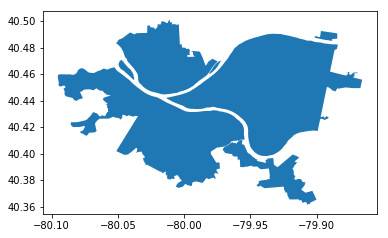

In [181]:
pgh_outbuff_gj.plot()

In [182]:
# Write out the buffered Pittsburgh geometry as a geojson file
pgh_outbuff_gj.to_file('allegheny_county/pgh/PghOutbuffExact.geojson', driver="GeoJSON")

In [72]:
nhbd_pgh_gj= gpd.sjoin(nhbd_gj, pgh_outbuff_gj, how="inner", op='within')


In [73]:
nhbd_pgh_gj

,Name,description,tessellate,extrude,visibility,snippet,geometry,index_right,city_name,in_pgh
SUMMER HILL,Summer Hill,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.00776399999999 40.483051, -80.0...",0,Pittsburgh,True
PERRY NORTH,Perry North,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.02570799999999 40.482791, -80.0...",0,Pittsburgh,True
BRIGHTON HEIGHTS,Brighton Heights,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.02789199999999 40.491075, -80.0...",0,Pittsburgh,True
HIGHLAND PARK,Highland Park,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-79.90597099999999 40.485224, -79.9...",0,Pittsburgh,True
NORTHVIEW HEIGHT,Northview Height,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.00776399999999 40.483051, -80.0...",0,Pittsburgh,True
MARSHALL-SHADELAND,Marshall-Shadeland,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.02570799999999 40.482791, -80.0...",0,Pittsburgh,True
PERRY SOUTH,Perry South,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.017413 40.477262, -80.017249000...",0,Pittsburgh,True
SPRING GARDEN,Spring Garden,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-79.99327700000001 40.461182, -79.9...",0,Pittsburgh,True
SPRING HILL-CITY VIEW,Spring Hill-City View,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-80.005117 40.472254, -80.005082 40...",0,Pittsburgh,True
EAST LIBERTY,East Liberty,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",-1,0,0,,"(POLYGON ((-79.92833 40.472339, -79.929834 40....",0,Pittsburgh,True


In [81]:
# Special case 'Mount Oliver Boro' to not be in Pittsburgh
nhbd_pgh_gj = nhbd_pgh_gj[nhbd_pgh_gj.Name!='Mount Oliver Boro'].copy()

In [171]:
# Write out a geojson with the geometry of mount oliver boro
nhbd_gj[nhbd_gj.Name=='Mount Oliver Boro'].to_file('allegheny_county/pgh/MtOliverBoro.geojson', driver="GeoJSON")

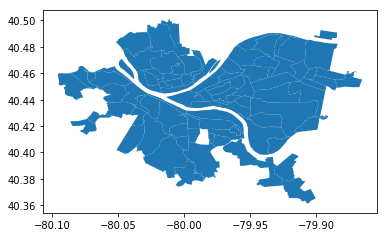

In [82]:
nhbd_pgh_gj[nhbd_pgh_gj.in_pgh==True].plot()

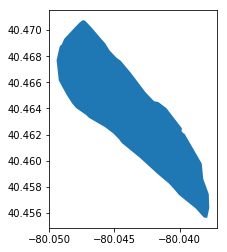

In [110]:
nhbd_pgh_gj[nhbd_pgh_gj.Name=='Brunots Island'].plot()

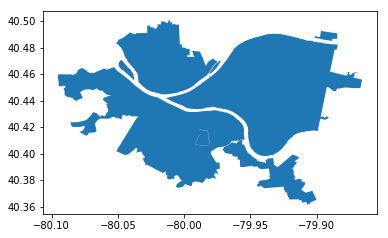

In [75]:
pgh_gj.plot()

In [ ]:
# Get rid of irrelevant columns
nhbd_pgh_out=gpd.GeoDataFrame(nhbd_pgh_gj[[ 'Name', 'city_name', 'geometry']].reset_index(), crs={'init': 'epsg:4326'},)

In [125]:
nhbd_pgh_out[55:58]

,index,Name,city_name,geometry
55,OAKWOOD,Oakwood,Pittsburgh,"(POLYGON ((-80.05915400000001 40.429331, -80.0..."
56,SOUTH SIDE FLATS,South Side Flats,Pittsburgh,"(POLYGON ((-79.961459 40.421374, -79.961442000..."
57,BEECHVIEW,Beechview,Pittsburgh,"(POLYGON ((-80.028021 40.429924, -80.028375 40..."


In [91]:
# Write out the Pittsburgh-only geojson file
nhbd_pgh_out.to_file('allegheny_county/pgh/PghNeighs.geojson', driver="GeoJSON")

In [185]:
binarize_geojson_outlines('allegheny_county/pgh/PghNeighs.geojson', 
                          'allegheny_county/pgh/PghNeighs.bin')

Read 91 features from allegheny_county/pgh/PghNeighs.geojson
10628 segments
Created allegheny_county/pgh/PghNeighs.bin (10628 segments)


# This section is a failed experiment in building up a single geometry from the neighborhood shapes that make up Pittsburgh

In [123]:
nhbd_pgh_gj[~pd.isna(nhbd_pgh_gj.geometry)][55:56].geometry

OAKWOOD    (POLYGON ((-80.05915400000001 40.429331, -80.0...
Name: geometry, dtype: object

In [130]:
# Collapse the exact geometry of Pgh into a single item for intersecting with blocks/blockgroups
nhbd_pgh_nn_gj = nhbd_pgh_gj[~pd.isna(nhbd_pgh_gj.geometry)].copy()

In [167]:
from shapely.ops import cascaded_union
pgh_flat_all=cascaded_union(pd.concat([nhbd_pgh_nn_gj[0:55],nhbd_pgh_nn_gj[56:70],nhbd_pgh_nn_gj[71:74]]).geometry)
pgh_flat_all

ValueError: No Shapely geometry can be created from null value

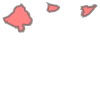

In [166]:
pgh_flat_rest = cascaded_union(nhbd_pgh_nn_gj[71:74].geometry)
pgh_flat_rest

# Check for completeness

In [128]:
for nhbd in sorted(all_nhbds):
    try:
        if nhbd in nhbd_gj.index:
            print "%s: Found" % (nhbd)
        else:
            print "%s: Missing" % (nhbd)
    except:
        print "  %s: MISSING" % (nhbd)

ALLEGHENY CENTER: Found
ALLEGHENY WEST: Found
ALLENTOWN: Found
ARLINGTON: Found
ARLINGTON HEIGHTS: Found
BALDWIN BOROUGH: Found
BALDWIN TOWNSHIP: Found
BANKSVILLE: Found
BEDFORD DWELLINGS: Found
BEECHVIEW: Found
BELLEVUE: Found
BELTZHOOVER: Found
BEN AVON: Found
BETHEL PARK: Found
BLOOMFIELD: Found
BLUFF: Found
BRACKENRIDGE: Found
BRADDOCK: Found
BRADDOCK HILLS: Found
BRENTWOOD: Found
BRIGHTON HEIGHTS: Found
BROOKLINE: Found
CALIFORNIA-KIRKBRIDE: Found
CARNEGIE: Found
CARRICK: Found
CENTRAL LAWRENCEVILLE: Found
CENTRAL NORTHSIDE: Found
CENTRAL OAKLAND: Found
CHARTIERS CITY: Found
CHURCHILL: Found
CLAIRTON: Found
COLLIER: Found
CORAOPOLIS: Found
CRAFTON: Found
CRAFTON HEIGHTS: Found
CRAWFORD-ROBERTS: Found
DORMONT: Found
DRAVOSBURG: Found
DUQUESNE: Found
DUQUESNE HEIGHTS: Found
EAST ALLEGHENY: Found
EAST CARNEGIE: Found
EAST HILLS: Found
EAST LIBERTY: Found
EAST PITTSBURGH: Found
ELIZABETH TOWNSHIP: Found
ELLIOTT: Found
ESPLEN: Found
ETNA: Found
FAIRYWOOD: Found
FINDLAY: Found
FINEVIEW:

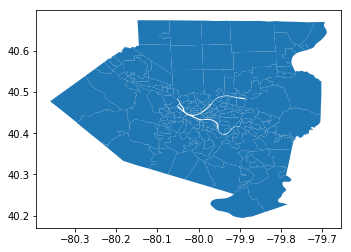

In [148]:
nhbd_gj_out=gpd.GeoDataFrame(nhbd_gj['geometry'].reset_index(), crs={'init': 'epsg:4326'},)
nhbd_gj_out.plot()

In [150]:
nhbd_gj_out.to_file('allegheny_county/dhs/AllegCo_Munis_PghNeighs_cap_2d.geojson', driver="GeoJSON")

## Write out neighborhood-based CSV

In [142]:
# Write out CSV for neighborhood per year
def write_hom_nhbd_gj_yr_chor_csv(out_path):
    date_range = range(2007, 2018)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("NAME,%s\n" % (",".join(map(str,date_range))))
    
    for nhbd in sorted(all_nhbds):
        out_data=[nhbd]
        
        for year in date_range:
            nhbd_yr_spec = '%s-%d' % (nhbd, year)
            val=0
            if(nhbd_yr_spec in hom_per_nhbd_year_map):
                val = hom_per_nhbd_year_map[nhbd_yr_spec]
            #print "%s: %d" % (nhbd_yr_spec,val)
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()


In [143]:
write_hom_nhbd_gj_yr_chor_csv('allegheny_county/homicides_per_nhbd_gj_year_2017_12_28.csv')

In [220]:
# Write out CSV for region per year
def write_hom_region_gj_yr_chor_csv(out_path):
    date_range = range(2007, 2018)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("NAME,%s\n" % (",".join(map(str,date_range))))
    
    for nhbd in sorted(all_nhbds):
        out_data=[nhbd]
        region = nhbd_to_region(nhbd)
        if(not region):
            continue
        for year in date_range:
            region_yr_spec = '%d-%d' % (region, year)
            val=0
            if region_yr_spec in hom_per_year_map:
                val = hom_per_year_map[region_yr_spec]
                print "%s = %s: %d" % (nhbd, region_yr_spec,val)
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()


In [221]:
write_hom_region_gj_yr_chor_csv('allegheny_county/homicides_per_region_gj_year_2017_12_28-c.csv')

ALLEGHENY CENTER = 1-2007: 9
ALLEGHENY CENTER = 1-2008: 13
ALLEGHENY CENTER = 1-2009: 8
ALLEGHENY CENTER = 1-2010: 10
ALLEGHENY CENTER = 1-2011: 11
ALLEGHENY CENTER = 1-2012: 6
ALLEGHENY CENTER = 1-2013: 4
ALLEGHENY CENTER = 1-2014: 9
ALLEGHENY CENTER = 1-2015: 13
ALLEGHENY CENTER = 1-2016: 20
ALLEGHENY CENTER = 1-2017: 11
ALLEGHENY WEST = 1-2007: 9
ALLEGHENY WEST = 1-2008: 13
ALLEGHENY WEST = 1-2009: 8
ALLEGHENY WEST = 1-2010: 10
ALLEGHENY WEST = 1-2011: 11
ALLEGHENY WEST = 1-2012: 6
ALLEGHENY WEST = 1-2013: 4
ALLEGHENY WEST = 1-2014: 9
ALLEGHENY WEST = 1-2015: 13
ALLEGHENY WEST = 1-2016: 20
ALLEGHENY WEST = 1-2017: 11
BELTZHOOVER = 3-2007: 4
BELTZHOOVER = 3-2008: 2
BELTZHOOVER = 3-2009: 3
BELTZHOOVER = 3-2010: 4
BELTZHOOVER = 3-2011: 4
BELTZHOOVER = 3-2012: 4
BELTZHOOVER = 3-2013: 5
BELTZHOOVER = 3-2014: 8
BELTZHOOVER = 3-2015: 4
BELTZHOOVER = 3-2016: 4
BELTZHOOVER = 3-2017: 5
BRADDOCK = 5-2007: 12
BRADDOCK = 5-2008: 8
BRADDOCK = 5-2009: 12
BRADDOCK = 5-2010: 10
BRADDOCK = 5-2011: 8


In [223]:
# Write out chart CSV for region per year
def write_hom_region_chart_yr_chor_csv(out_path):
    date_range = range(2007, 2018)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("NAME,%s\n" % (",".join(map(str,date_range))))
    
    for region in sorted(set(nhbd_to_region_map.values())):
        out_data=["Region %d"%(region)]
        for year in date_range:
            region_yr_spec = '%d-%d' % (region, year)
            val=0
            if region_yr_spec in hom_per_year_map:
                val = hom_per_year_map[region_yr_spec]
                print "%s: %d" % (region_yr_spec,val)
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()


In [225]:
write_hom_region_chart_yr_chor_csv('allegheny_county/homicides_per_region_chart_year_2017_12_28.csv')

1-2007: 9
1-2008: 13
1-2009: 8
1-2010: 10
1-2011: 11
1-2012: 6
1-2013: 4
1-2014: 9
1-2015: 13
1-2016: 20
1-2017: 11
2-2007: 3
2-2008: 3
2-2009: 2
2-2010: 3
2-2011: 5
2-2012: 2
2-2013: 2
2-2014: 2
2-2015: 2
2-2017: 4
3-2007: 4
3-2008: 2
3-2009: 3
3-2010: 4
3-2011: 4
3-2012: 4
3-2013: 5
3-2014: 8
3-2015: 4
3-2016: 4
3-2017: 5
4-2007: 18
4-2008: 21
4-2009: 13
4-2010: 21
4-2011: 12
4-2012: 20
4-2013: 18
4-2014: 26
4-2015: 16
4-2016: 25
4-2017: 17
5-2007: 12
5-2008: 8
5-2009: 12
5-2010: 10
5-2011: 8
5-2012: 13
5-2013: 12
5-2014: 17
5-2015: 14
5-2016: 7
5-2017: 16


In [11]:
#Neighborhoods/census blocks/populations

In [12]:
nbhd_blks = pd.read_excel("allegheny_county/dhs/Neighborhood tracts blocks.xlsx")
nbhd_blks

,source: PNCIS city of Pittsburgh neighborhood profiles: Census 2010 Summary File 1 data,neighborhood,Unnamed: 2,Unnamed: 3,tract,block,Unnamed: 6,unique tracts,count of tracts,neighborhood.1,Unnamed: 10,Unnamed: 11,tract.1,block.1,Unnamed: 14,comb,Unnamed: 16,Unnamed: 17,comb.1,Unnamed: 19,Unnamed: 20,Unnamed: 21,tracts crossing neighbohoods,neighborhoods,Unnamed: 24,neighborhoods sharing tracts with other neighbohoods
0,NaN,Allegheny,Center,NaN,5627,2,NaN,103.0,137.0,Bluff,NaN,NaN,103,1,NaN,Bluff 103,NaN,NaN,Bluff,103.0,NaN,NaN,402,TerraceVillage,NaN,AlleghenyCenter
1,NaN,Allegheny,West,NaN,5627,1,NaN,201.0,NaN,Bluff,NaN,NaN,103,2,NaN,Bluff 103,NaN,NaN,CentralBusinessDistrict,201.0,NaN,NaN,NaN,WestOakland,NaN,AlleghenyWest
2,NaN,Allentown,NaN,NaN,1803,1,NaN,203.0,NaN,Bluff,NaN,NaN,103,3,NaN,Bluff 103,NaN,NaN,StripDistrict,203.0,NaN,NaN,5616,Arlington,NaN,Arlington
3,NaN,Allentown,NaN,NaN,1803,2,NaN,305.0,NaN,Bluff,NaN,NaN,103,4,NaN,Bluff 103,NaN,NaN,Crawford‐Roberts,305.0,NaN,NaN,NaN,ArlingtonHeights,NaN,ArlingtonHeights
4,NaN,Allentown,NaN,NaN,1803,v,NaN,402.0,NaN,Central,Business,District,201,1,NaN,CentralBusinessDistrict 201,NaN,NaN,TerraceVillage,402.0,1.0,NaN,5617,Mt.Oliver,NaN,Beltzhoover
5,NaN,Arlington,NaN,NaN,5616,2,NaN,404.0,NaN,Central,Business,District,201,2,NaN,CentralBusinessDistrict 201,NaN,NaN,WestOakland,402.0,NaN,NaN,NaN,St.Clair,NaN,BonAir
6,NaN,Arlington,NaN,NaN,5616,3,NaN,405.0,NaN,Central,Business,District,201,3,NaN,CentralBusinessDistrict 201,NaN,NaN,NorthOakland,404.0,NaN,NaN,5623,GlenHazel,NaN,ChartiersCity
7,NaN,Arlington,NaN,NaN,5616,4,NaN,406.0,NaN,Central,Business,District,201,4,NaN,CentralBusinessDistrict 201,NaN,NaN,CentralOakland,405.0,NaN,NaN,NaN,Hazelwood,NaN,EastAllegheny
8,NaN,Arlington,Heights,NaN,5616,1,NaN,409.0,NaN,Central,Business,District,201,5,NaN,CentralBusinessDistrict 201,NaN,NaN,CentralOakland,406.0,NaN,NaN,5624,Beltzhoover,NaN,EastCarnegie
9,NaN,Banksville,NaN,NaN,2023,1,NaN,501.0,NaN,Central,Business,District,201,6,NaN,CentralBusinessDistrict 201,NaN,NaN,SouthOakland,409.0,NaN,NaN,NaN,BonAir,NaN,Elliott
